In [29]:
'''
Machine learning for the 2D planestress problem using CNN
Last Updated : 04/04/2019, by Hyungmin Jun (hyungminjun@outlook.com)

=============================================================================

Copyright 2019 Hyungmin Jun. All rights reserved.

License - GPL version 3
This program is free software: you can redistribute it and/or modify it under
the terms of the GNU General Public License as published by the Free Software
Foundation, either version 3 of the License, or any later version. This
program is distributed in the hope that it will be useful, but WITHOUT ANY
WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR
A PARTICULAR PURPOSE. See the GNU General Public License for more details.
You should have received a copy of the GNU General Public License along with
this program. If not, see <http://www.gnu.org/licenses/>.
'''

'\nMachine learning for the 2D planestress problem using CNN\nLast Updated : 04/04/2019, by Hyungmin Jun (hyungminjun@outlook.com)\n\n=============================================================================\n\nCopyright 2019 Hyungmin Jun. All rights reserved.\n\nLicense - GPL version 3\nThis program is free software: you can redistribute it and/or modify it under\nthe terms of the GNU General Public License as published by the Free Software\nFoundation, either version 3 of the License, or any later version. This\nprogram is distributed in the hope that it will be useful, but WITHOUT ANY\nWARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR\nA PARTICULAR PURPOSE. See the GNU General Public License for more details.\nYou should have received a copy of the GNU General Public License along with\nthis program. If not, see <http://www.gnu.org/licenses/>.\n'

In [30]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import time

from numpy.linalg import inv

from keras.models import Sequential
from keras.layers import Dense
from numpy.linalg import inv

import keras.layers as kl
import keras.models as km

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

In [31]:
allfiles = glob.glob('../data/stress_planestress\\*.csv')

num_datapoints = 1071

in_data  = np.zeros([len(allfiles) * num_datapoints, 3])
out_data = np.zeros(len(allfiles) * num_datapoints)

for i, datafile in enumerate(allfiles):
    
    force = int(datafile.split('\\')[1].split('-')[0]) / float(50000)
    
    # Set force data
    in_data[i * num_datapoints:(i + 1) * num_datapoints, 0] = np.array([force] * num_datapoints)
    
    data = np.loadtxt(fname = datafile, delimiter = ' ')
    
    # Set x position
    in_data[i * num_datapoints:(i + 1) * num_datapoints, 1] = data[:, 0]
    
    # Set y posistion
    in_data[i * num_datapoints:(i + 1) * num_datapoints, 2] = data[:, 1]
    
    # Set the stress
    out_data[i * num_datapoints:(i + 1) * num_datapoints] = data[:, 3] / float(50000)
    
x_train, x_test, y_train, y_test = train_test_split(in_data, out_data, test_size = 0.1)
xy_train    = x_train[:,1:]
force_train = x_train[:,0]

In [32]:
def abs_pred(y_true, y_pred):
        return abs((y_true - y_pred) / y_true) < 0.1

In [33]:
start_time = time.time()

numnodes = 10

# https://keras.io/getting-started/functional-api-guide/
# https://stackoverflow.com/questions/45930844/how-to-merge-keras-sequential-models-with-same-input

i_pos = kl.Input(shape = (2, ))
i_for = kl.Input(shape = (1, ))

x_pos = kl.Dense(numnodes, activation = 'tanh')(i_pos)
x_for = kl.Dense(numnodes, activation = 'relu')(i_for)

x     = kl.concatenate(inputs = [x_pos, x_for])

x     = kl.Dense(numnodes, activation = 'tanh')(x)
x     = kl.Dense(numnodes, activation = 'tanh')(x)
x     = kl.Dense(1,        activation = 'linear')(x)

model = km.Model(inputs = [i_pos, i_for], outputs = x)

model.compile(optimizer = 'adam', metrics = ['accuracy', abs_pred], loss = 'mean_absolute_error')

model.summary()

hist = model.fit([xy_train, force_train], y_train, epochs = 50, batch_size = 100, verbose = 2)
print("--- %s fitting (seconds) ---" % (time.time() - start_time))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 2)            0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_45 (Dense)                (None, 10)           30          input_21[0][0]                   
__________________________________________________________________________________________________
dense_46 (Dense)                (None, 10)           20          input_22[0][0]                   
__________________________________________________________________________________________________
concatenat

In [34]:
from numpy import genfromtxt

data  = genfromtxt('../data/stress_planestress\\0-sigmaSurface.csv', delimiter=' ')
sigma = np.zeros(shape=(1, 1071))
sigma.fill(1000/50000)

coordinates = data[:, [0,1]].T
start_time  = time.time()
y_pred      = model.predict([coordinates.T, sigma.T])

print("--- %s seconds ---" % (time.time() - start_time))

y_predScaled = y_pred*50000
print(y_pred.shape)

--- 0.1506938934326172 seconds ---
(1071, 1)


In [35]:
def griddata(x, y, z, binsize=0.01, retbin=True, retloc=True):
    """
    Place unevenly spaced 2D data on a grid by 2D binning (nearest neighbor interpolation).
    
    Parameters
    ----------
    x : ndarray (1D)
        The idependent data x-axis of the grid.
    y : ndarray (1D)
        The idependent data y-axis of the grid.
    z : ndarray (1D)
        The dependent data in the form z = f(x,y).
    binsize : scalar, optional
        The full width and height of each bin on the grid.  If each
        bin is a cube, then this is the x and y dimension.  This is
        the step in both directions, x and y. Defaults to 0.01.
    retbin : boolean, optional
        Function returns `bins` variable (see below for description)
        if set to True.  Defaults to True.
    retloc : boolean, optional
        Function returns `wherebins` variable (see below for description)
        if set to True.  Defaults to True.
   
    Returns
    -------
    grid : ndarray (2D)
        The evenly gridded data.  The value of each cell is the median
        value of the contents of the bin.
    bins : ndarray (2D)
        A grid the same shape as `grid`, except the value of each cell
        is the number of points in that bin.  Returns only if
        `retbin` is set to True.
    wherebin : list (2D)
        A 2D list the same shape as `grid` and `bins` where each cell
        contains the indicies of `z` which contain the values stored
        in the particular bin.
    Revisions
    ---------
    2010-07-11  ccampo  Initial version
    """
    # get extrema values.
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()

    # make coordinate arrays.
    xi     = np.arange(xmin, xmax+binsize, binsize)
    yi     = np.arange(ymin, ymax+binsize, binsize)
    xi, yi = np.meshgrid(xi,yi)

    # make the grid.
    grid       = np.zeros(xi.shape, dtype=x.dtype)
    nrow, ncol = grid.shape
    if retbin: bins = np.copy(grid)

    # create list in same shape as grid to store indices
    if retloc:
        wherebin = np.copy(grid)
        wherebin = wherebin.tolist()

    # fill in the grid.
    for row in range(nrow):
        for col in range(ncol):
            xc = xi[row, col]    # x coordinate.
            yc = yi[row, col]    # y coordinate.

            # find the position that xc and yc correspond to.
            posx = np.abs(x - xc)
            posy = np.abs(y - yc)
            ibin = np.logical_and(posx < binsize/2., posy < binsize/2.)
            ind  = np.where(ibin == True)[0]

            # fill the bin.
            bin = z[ibin]
            if retloc: wherebin[row][col] = ind
            if retbin: bins[row, col] = bin.size
            if bin.size != 0:
                binval         = np.median(bin)
                grid[row, col] = binval
            else:
                grid[row, col] = np.nan   # fill empty bins with nans.

    # return the grid
    if retbin:
        if retloc:
            return grid, bins, wherebin
        else:
            return grid, bins
    else:
        if retloc:
            return grid, wherebin
        else:
            return grid

In [36]:
def griddata_import(x, y, z, binsize=0.01, retbin=True, retloc=True):

    # get extrema values.
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()

    # make coordinate arrays.
    xi     = np.arange(xmin, xmax+binsize, binsize)
    yi     = np.arange(ymin, ymax+binsize, binsize)
    xi, yi = np.meshgrid(xi,yi)

    # make the grid.
    grid       = np.zeros(xi.shape, dtype=x.dtype)
    nrow, ncol = grid.shape
    if retbin: bins = np.copy(grid)

    # create list in same shape as grid to store indices
    if retloc:
        wherebin = np.copy(grid)
        wherebin = wherebin.tolist()

    # fill in the grid.
    for row in range(nrow):
        for col in range(ncol):
            xc = xi[row, col]    # x coordinate.
            yc = yi[row, col]    # y coordinate.

            # find the position that xc and yc correspond to.
            posx = np.abs(x - xc)
            posy = np.abs(y - yc)
            ibin = np.logical_and(posx < binsize/2., posy < binsize/2.)
            ind  = np.where(ibin == True)[0]

            # fill the bin.
            bin = z[ibin]
            if retloc: wherebin[row][col] = ind
            if retbin: bins[row, col] = bin.size
            if bin.size != 0:
                binval         = np.median(bin)
                grid[row, col] = binval
            else:
                grid[row, col] = np.nan   # fill empty bins with nans.

    # return the grid
    if retbin:
        if retloc:
            return grid, bins, wherebin
        else:
            return grid, bins
    else:
        if retloc:
            return grid, wherebin
        else:
            return grid

--- 0.01995110511779785 seconds ---


Text(0, 0.5, 'Y values')

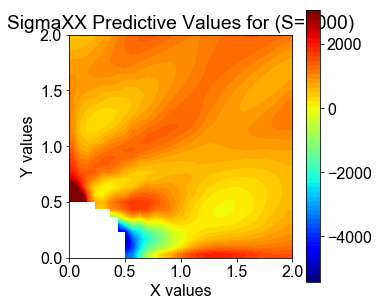

In [37]:
start_time = time.time()

y_pred = model.predict([coordinates.T, sigma.T])

print("--- %s seconds ---" % (time.time() - start_time))

y_predScaled=y_pred*50000
# In[5]:
#import Image
xx = coordinates[0,]
yy = coordinates[1,]
zz = y_predScaled
x  = xx.ravel()
y  = yy.ravel()
z  = zz.ravel()
xi = np.linspace(0, 2, 5000)
yi = np.linspace(0, 2, 5000)

binsize = 0.07
grid, bins, binloc = griddata_import(x, y, z, binsize=binsize)
zmin    = grid[np.where(np.isnan(grid) == False)].min()
zmax    = grid[np.where(np.isnan(grid) == False)].max()

palette = plt.matplotlib.colors.LinearSegmentedColormap('jet1', plt.cm.datad['jet'], 60)
palette.set_under(alpha=0.0)
extent = (x.min(), x.max(), y.min(), y.max())
plt.rcParams["font.family"] = "arial"
plt.rcParams["font.size"] = "16"
plt.figure(figsize=(5, 5))
plt.imshow(grid, extent=extent, cmap=palette, origin='lower', vmin=zmin, vmax=3050, aspect='1', interpolation='bilinear')
cbar=plt.colorbar()

plt.title('SigmaXX Predictive Values for (S=1000)')
plt.xlabel('X values')
plt.ylabel('Y values')
#plt.savefig('testplot.png')
#Image.open('testplot.png').save('testplot.jpg','JPEG')

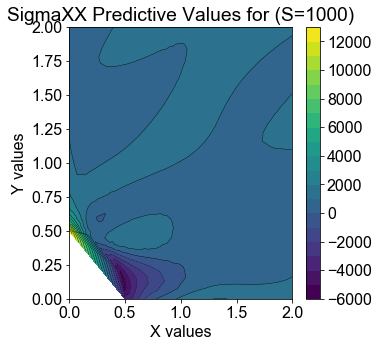

In [38]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.tri as tri

xx = coordinates[0,]
yy = coordinates[1,]
zz = y_predScaled
x  = xx.ravel()
y  = yy.ravel()
z  = zz.ravel()
xi = np.linspace(0, 2, 5000)
yi = np.linspace(0, 2, 5000)
#zi = mlab.griddata(x, y, z, xi, yi)
triang = tri.Triangulation(x, y)

zmin = grid[np.where(np.isnan(grid) == False)].min()
zmax = grid[np.where(np.isnan(grid) == False)].max()

plt.figure(figsize=(5, 5))
plt.tricontour(x, y, z, 20, linewidths=0.4, colors='k')
plt.tricontourf(x, y, z, 20, norm=plt.Normalize(vmax=zmax, vmin=zmin))
#plt.subplots_adjust(hspace=0.5)
plt.colorbar() 
plt.title('SigmaXX Predictive Values for (S=1000)')
plt.xlabel('X values')
plt.ylabel('Y values')
#plt.savefig('result.png')
# griddata and contour.
#xi = np.linspace(0, 2, 1000)
#yi = np.linspace(0, 2, 1000)
#zi = mlab.griddata(x, y, z, xi, yi)

#plt.contour(xi, yi, zi, 20, interp='linear', linewidths=0.5, colors=('r', 'green', 'blue' ))
#plt.contourf(xi, yi, zi, 20,
             #norm=plt.Normalize(vmax=zmax, vmin=zmin)
plt.show()